In [1]:
from typing import List
import networkx as nx
import numpy as np
import pandas as pd
import datetime
from hatch import contributions_to_token_batches, TokenBatch, Commons
from convictionvoting import trigger_threshold
from network_helpers import *
from IPython.core.debugger import set_trace

from cadCAD.configuration import Configuration


def initialize_network_of_hatchers(participants: List[TokenBatch]) -> nx.DiGraph:
    """
    The role of this function is simply to fill up the directed graph.
    Helper functions setting up the tokens etc should be defined elsewhere
    and only provide values to this dumb function to put in the graph.
    """
    network = nx.DiGraph()
    for i, p in enumerate(participants):
        # Note: TokenBatch arguments don't mean anything if they're nonvesting
        network.add_node(i, type="participant", holdings_vesting=p, holdings_nonvesting=TokenBatch(0, 5, 5), sentiment=np.random.rand())
    return network


# The cell below is for copy/pasting policy functions from libraries into, for debugging

In [2]:
# contributions = [5e5, 5e5, 2.5e5]
contributions = [np.random.rand() * 10e5 for i in range(60)]
token_batches, initial_token_supply = contributions_to_token_batches(contributions, 0.1, 60)

network = initialize_network_of_hatchers(token_batches)
commons = Commons(sum(contributions), initial_token_supply, exit_tribute=0.35)
network = add_proposals_and_relationships_to_network(network, 3, commons._funding_pool, commons._token_supply)

initial_conditions = {
    "network": network,
    "commons": commons,
    "funding_pool": commons._funding_pool,
    "collateral_pool": commons._collateral_pool,
    "token_supply": commons._token_supply,
    "sentiment": 0.5
}

partial_state_update_blocks = [
    {
        "policies": {
            "gen_new_participants_proposals_funding": gen_new_participants_proposals_funding_randomly
        },
        'variables': {
            'network': add_participants_proposals_to_network,
            'commons': new_participants_and_new_funds_commons,
        }
    },
    {
        "policies": {},
        "variables": {
            "funding_pool": update_funding_pool,
            "collateral_pool": update_collateral_pool,
            "token_supply": update_token_supply,
        }
    },
    {
        "policies": {
            "make_active_proposals_complete_or_fail": make_active_proposals_complete_or_fail_randomly,
        },
        "variables": {
            "sentiment": sentiment_decays_wo_completed_proposals,
            "network": update_network_w_proposal_status,
        }
    },
    {
        "policies": {
            "decide_proposals_to_fund": conviction_gathering,
        },
        "variables": {
            'commons': decrement_commons_funding_pool, #funds expended
            'sentiment': update_sentiment_on_release, #releasing funds can bump sentiment
#             'network': update_proposals #reset convictions, and participants sentiments
#                                         #update based on affinities
        }
    },
    {
        "policies": {},
        "variables": {
            "funding_pool": update_funding_pool,
            "collateral_pool": update_collateral_pool,
            "token_supply": update_token_supply,
        }
    },
]

In [3]:
simulation_parameters = {
    'T': range(150),
    'N': 1,
    'M': {
        "sentiment_decay": 0.01, #termed mu in the state update function
        "trigger_threshold": trigger_threshold,
        "min_proposal_age_days": 7, # minimum periods passed before a proposal can pass
    }
}

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The configurations above are then packaged into a `Configuration` object
config = Configuration(initial_state=initial_conditions, #dict containing variable names and initial values
                       partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
                       sim_config=simulation_parameters #dict containing simulation parameters
                      )


from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.single_proc) # Do not use multi_proc, breaks ipdb.set_trace()
executor = Executor(exec_context, [config]) # Pass the configuration object inside an array
raw_result, tensor = executor.execute() # The `execute()` method returns a tuple; its first elements contains the raw results


                            __________   ____ 
          ________ __ _____/ ____/   |  / __ \
         / ___/ __` / __  / /   / /| | / / / /
        / /__/ /_/ / /_/ / /___/ ___ |/ /_/ / 
        \___/\__,_/\__,_/\____/_/  |_/_____/  
        by BlockScience
        
Execution Mode: single_proc: [<cadCAD.configuration.Configuration object at 0x7f7d71e7d520>]
Configurations: [<cadCAD.configuration.Configuration object at 0x7f7d71e7d520>]
{'new_participant': False, 'new_participant_investment': 0, 'new_participant_tokens': 0, 'new_proposal': False, 'funds_arrival': 12.939830560569147}
{'completed': [], 'failed': []}
{'accepted': [], 'triggers': {60: 131203560.64947198, 61: 129278619.10924178, 62: 133114951.90230455}}
{'new_participant': True, 'new_participant_investment': 184.37391443810046, 'new_participant_tokens': 1152.3369652381277, 'new_proposal': False, 'funds_arrival': 470.08188655866076}
{'completed': [], 'failed': []}
{'accepted': [], 'triggers': {60: 131203451.94956434, 61: 12

{'new_participant': False, 'new_participant_investment': 0, 'new_participant_tokens': 0, 'new_proposal': False, 'funds_arrival': 607.2573790563774}
{'completed': [], 'failed': []}
{'accepted': [], 'triggers': {60: 131188738.23467535, 61: 129268263.38557097, 62: 133095600.88699806, 64: 172623994.88819167, 65: 152732855.17239982, 67: 154272381.18054983, 69: 203999598.3844638, 70: 153075114.69146302, 71: 166097675.70321795, 72: 177272349.6818715}}
{'new_participant': False, 'new_participant_investment': 0, 'new_participant_tokens': 0, 'new_proposal': False, 'funds_arrival': 327.1217634348747}
{'completed': [], 'failed': []}
{'accepted': [], 'triggers': {60: 131188240.39305927, 61: 129267901.48017532, 62: 133094965.24670638, 64: 172619899.89754605, 65: 152730641.24315795, 67: 154270031.5739251, 69: 203991998.5468416, 70: 153072870.74586797, 71: 166094228.12143674, 72: 177267776.00999197}}
{'new_participant': False, 'new_participant_investment': 0, 'new_participant_tokens': 0, 'new_proposal

{'new_participant': False, 'new_participant_investment': 0, 'new_participant_tokens': 0, 'new_proposal': False, 'funds_arrival': 177.57363673048994}
{'completed': [], 'failed': []}
{'accepted': [], 'triggers': {60: 131183755.73612323, 61: 129264921.01525153, 62: 133088955.48591904, 64: 172575541.19770005, 65: 152707147.02492973, 67: 154245033.20305678, 69: 203908724.2566307, 70: 153049043.77124745, 71: 166057052.7051873, 72: 177218104.87093106, 73: 203196703.85304436, 74: 133419068.58006674, 77: 151355894.60764092}}
{'new_participant': True, 'new_participant_investment': 23.884043290127728, 'new_participant_tokens': 149.27219356868062, 'new_proposal': False, 'funds_arrival': 325.4262057411701}
{'completed': [], 'failed': []}
{'accepted': [], 'triggers': {60: 131183340.29530266, 61: 129264639.41908565, 62: 133088404.34729178, 64: 172571579.61103174, 65: 152705040.62200275, 67: 154242793.0342624, 69: 203901303.7893218, 70: 153046907.77559465, 71: 166053729.75559074, 72: 177213671.0173565

{'new_participant': False, 'new_participant_investment': 0, 'new_participant_tokens': 0, 'new_proposal': False, 'funds_arrival': 536.8194572838239}
{'completed': [], 'failed': []}
{'accepted': [], 'triggers': {60: 131174530.6822145, 61: 129258253.63056082, 62: 133077137.82842723, 64: 172498667.15855342, 65: 152665641.71587098, 67: 154200976.34057483, 69: 203765982.21531573, 70: 153006973.96681428, 71: 165992350.06220543, 72: 177132232.49803203, 73: 203055589.48788905, 74: 133406796.35263988, 77: 151316604.84234625, 80: 161844158.10338998, 81: 169562624.40251878, 83: 210879755.29737493}}
{'new_participant': True, 'new_participant_investment': 133.32120454728437, 'new_participant_tokens': 833.2393946886731, 'new_proposal': False, 'funds_arrival': 288.4363421428368}
{'completed': [], 'failed': []}
{'accepted': [], 'triggers': {60: 131174534.50180803, 61: 129258370.34694111, 62: 133077027.08077358, 64: 172495654.89085376, 65: 152664212.00565755, 67: 154199432.79516762, 69: 203760004.803997

{'accepted': [], 'triggers': {60: 131165034.95119959, 61: 129251627.45425157, 62: 133064733.23904854, 64: 172413254.736917, 65: 152619923.09624937, 67: 154152394.23403448, 69: 203606649.29082444, 70: 152960621.84299475, 71: 165920597.57941404, 72: 177036721.2828787, 73: 202898083.11464557, 74: 133393881.73286174, 77: 151273372.60143176, 80: 161780792.47078243, 81: 169483452.00537875, 83: 210701766.60161132, 85: 240447864.67208835, 87: 148123703.72027075, 90: 163877258.4867679, 91: 162179070.30692434}}
{'new_participant': True, 'new_participant_investment': 148.76141164940893, 'new_participant_tokens': 929.7309866393329, 'new_proposal': False, 'funds_arrival': 484.0715263341541}
{'completed': [], 'failed': []}
{'accepted': [], 'triggers': {60: 131164795.4841433, 61: 129251580.48293813, 62: 133064298.51901685, 64: 172407894.56888446, 65: 152617245.60661384, 67: 154149523.52579936, 69: 203596276.82030252, 70: 152957901.6115245, 71: 165916161.54493025, 72: 177030677.38902563, 73: 202887834

{'new_participant': True, 'new_participant_investment': 62.50064050525738, 'new_participant_tokens': 390.6146249602769, 'new_proposal': False, 'funds_arrival': 94.49179856779831}
{'completed': [], 'failed': []}
{'accepted': [], 'triggers': {60: 131159166.53081153, 61: 129247647.25482202, 62: 133056950.7092105, 64: 172357429.7818719, 65: 152590218.1928403, 67: 154120804.99607545, 69: 203502188.3855378, 70: 152930500.05803657, 71: 165873761.18430394, 72: 176974251.26390934, 73: 202794823.86447415, 74: 133385763.58652042, 77: 151245303.87729517, 80: 161739474.9404833, 81: 169431733.10011527, 83: 210585032.77433482, 85: 240275056.9593989, 87: 148099390.24655014, 90: 163833166.95762065, 91: 162137229.08784053, 93: 140532726.25239208, 95: 164875354.69602063}}
{'new_participant': False, 'new_participant_investment': 0, 'new_participant_tokens': 0, 'new_proposal': True, 'funds_arrival': 266.4173800169176}
{'completed': [], 'failed': []}
{'accepted': [], 'triggers': {60: 131158764.74029744, 61:

{'new_participant': True, 'new_participant_investment': 0.7026535536491274, 'new_participant_tokens': 4.391405456515731, 'new_proposal': False, 'funds_arrival': 531.191372687182}
{'completed': [], 'failed': []}
{'accepted': [], 'triggers': {60: 131148724.20297794, 61: 129240138.4444288, 62: 133043535.21567918, 64: 172269516.26903963, 65: 152542783.38958946, 67: 154070448.32597575, 69: 203338999.9068521, 70: 152882418.80831757, 71: 165799772.19687766, 72: 176876046.60831946, 73: 202633494.07089177, 74: 133371826.84020141, 77: 151200406.39733365, 80: 161674037.97879213, 81: 169350179.82361755, 83: 210402863.65012735, 85: 240006221.37421438, 87: 148060317.17964718, 90: 163763431.1550736, 91: 162070980.52974433, 93: 140507018.459042, 95: 164803454.46509317, 98: 204715266.18903908}}
{'new_participant': False, 'new_participant_investment': 0, 'new_participant_tokens': 0, 'new_proposal': True, 'funds_arrival': 63.145204900329766}
{'completed': [], 'failed': []}
{'accepted': [], 'triggers': {6

{'new_participant': False, 'new_participant_investment': 0, 'new_participant_tokens': 0, 'new_proposal': False, 'funds_arrival': 510.8894443014161}
{'completed': [], 'failed': []}
{'accepted': [], 'triggers': {60: 131140838.16877623, 61: 129234536.17871852, 62: 133033334.59456009, 64: 172201334.98669904, 65: 152506102.44729087, 67: 154031493.32045802, 69: 203212260.2572484, 70: 152845234.7385479, 71: 165742425.98866442, 72: 176799858.08845806, 73: 202508200.05229455, 74: 133361220.43275267, 77: 151165700.2680352, 80: 161623346.82174072, 81: 169286947.50737798, 83: 210261362.1880012, 85: 239797333.6453695, 87: 148030144.3537512, 90: 163709394.6622896, 91: 162019657.7854331, 93: 140487248.89307874, 95: 164747733.66041628, 98: 204585691.3967606, 104: 150954966.5947277}}
{'new_participant': False, 'new_participant_investment': 0, 'new_participant_tokens': 0, 'new_proposal': False, 'funds_arrival': 1124.1351914791137}
{'completed': [], 'failed': []}
{'accepted': [], 'triggers': {60: 1311391

{'completed': [], 'failed': []}
{'accepted': [], 'triggers': {60: 131129841.94181919, 61: 129226544.13491568, 62: 133019294.0086413, 64: 172111116.02362844, 65: 152457253.63205728, 67: 153979656.76508015, 69: 203045204.6032575, 70: 152795724.8799981, 71: 165666433.3612774, 72: 176699127.8274095, 73: 202343040.41655675, 74: 133346646.15538776, 77: 151119446.1962614, 80: 161556093.98748466, 81: 169203226.05688956, 83: 210074947.7674937, 85: 239522590.63722453, 87: 147989847.29103747, 90: 163637748.36379573, 91: 161951575.45280606, 93: 140460625.84406695, 95: 164673875.47488126, 98: 204414917.41844383, 104: 150909117.84182608, 108: 155156121.37588117, 109: 146005492.2555502}}
{'new_participant': False, 'new_participant_investment': 0, 'new_participant_tokens': 0, 'new_proposal': False, 'funds_arrival': 325.6419514975753}
{'completed': [], 'failed': []}
{'accepted': [], 'triggers': {60: 131129354.93373749, 61: 129226190.03789616, 62: 133018672.31657173, 64: 172107125.29501283, 65: 15245509

{'accepted': [], 'triggers': {60: 131124640.64768842, 61: 129222783.6210253, 62: 133012632.71057808, 64: 172067933.4768295, 65: 152433901.98274058, 67: 153954872.73571602, 69: 202965203.60202292, 70: 152772056.31096408, 71: 165630069.60635757, 72: 176650907.53542095, 73: 202263947.7627774, 74: 133339728.91579768, 77: 151097338.54379982, 80: 161523919.60678077, 81: 169163157.73854363, 83: 209985672.81861162, 85: 239391011.47615108, 87: 147970595.70207047, 90: 163603467.96723095, 91: 161919003.44543055, 93: 140447930.73886955, 95: 164638534.8301867, 98: 204333135.06120074, 104: 150887204.5135243, 108: 155130218.30205452, 109: 145988012.0467128, 111: 208107221.27924293, 112: 137869206.6075129}}
{'new_participant': False, 'new_participant_investment': 0, 'new_participant_tokens': 0, 'new_proposal': False, 'funds_arrival': 479.8949084089792}
{'completed': [], 'failed': []}
{'accepted': [], 'triggers': {60: 131123924.02692108, 61: 129222262.56727622, 62: 133011717.92013662, 64: 172062063.115

{'completed': [], 'failed': []}
{'accepted': [], 'triggers': {60: 131118188.14876406, 61: 129218159.36849995, 62: 133004327.58803843, 64: 172013292.03054604, 65: 152404419.48820126, 67: 153923572.89779717, 69: 202863860.51040152, 70: 152742171.72044274, 71: 165584078.58711383, 72: 176589875.38924444, 73: 202163756.71499503, 74: 133331099.02647363, 77: 151069434.3951893, 80: 161483243.50020388, 81: 169112467.00038403, 83: 209872568.07440972, 85: 239224262.39365593, 87: 147946315.29458085, 90: 163560120.0121425, 91: 161877822.87698337, 93: 140431969.40238982, 95: 164593841.78053656, 98: 204229532.7201498, 104: 150859546.91885906, 108: 155097498.6807651, 109: 145965979.18353796, 111: 207997304.0450096, 112: 137855965.148874, 113: 191522374.49912733, 114: 157482578.40513322, 115: 170908812.78593218}}
{'new_participant': False, 'new_participant_investment': 0, 'new_participant_tokens': 0, 'new_proposal': False, 'funds_arrival': 101.16152405405593}
{'completed': [], 'failed': []}
{'accepted'

{'new_participant': False, 'new_participant_investment': 0, 'new_participant_tokens': 0, 'new_proposal': True, 'funds_arrival': 109.43198048241129}
{'completed': [], 'failed': []}
{'accepted': [], 'triggers': {60: 131112152.77132447, 61: 129213851.80320163, 62: 132996541.4053677, 64: 171961728.27932355, 65: 152376622.70968103, 67: 153894059.1279469, 69: 202768192.2222975, 70: 152713995.04648045, 71: 165540686.0213451, 72: 176532275.3839457, 73: 202069176.2257025, 74: 133323005.9304562, 77: 151043128.8346379, 80: 161444871.71670482, 81: 169064635.00622553, 83: 209765794.5054938, 85: 239066848.0963554, 87: 147923433.53384295, 90: 163519224.21040812, 91: 161838974.53798044, 93: 140416948.23910537, 95: 164551675.33086306, 98: 204131731.19640067, 104: 150833474.3042474, 108: 155066643.54938272, 109: 145945221.02741888, 111: 207893540.0202745, 112: 137843514.13842806, 113: 191443839.74933958, 114: 157448959.142715, 115: 170858678.55867177, 118: 307448321.31064147}}
{'new_participant': False,

In [4]:
df = pd.DataFrame(raw_result)
df_final = df[df.substep.eq(2)]


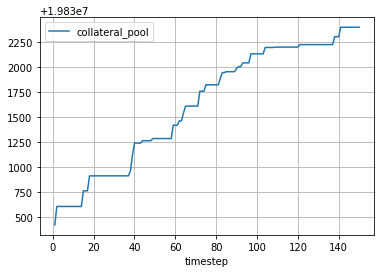

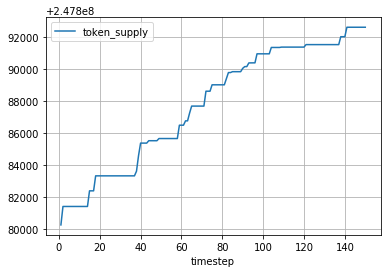

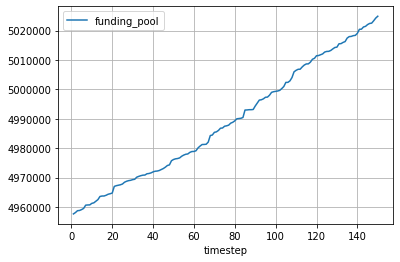

In [5]:
df_final.plot("timestep", "collateral_pool", grid=True)
df_final.plot("timestep", "token_supply", grid=True)
df_final.plot("timestep", "funding_pool", grid=True)

Text(0.5, 1.0, 'Participants Social Network')

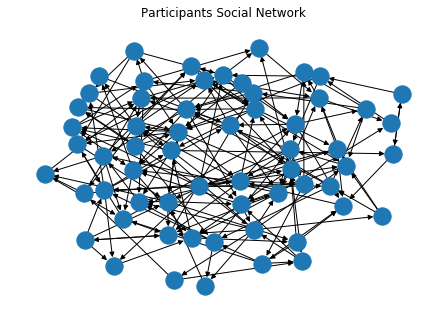

In [6]:
import matplotlib.pyplot as plt
supporters = get_edges_by_type(network, 'support')
influencers = get_edges_by_type(network, 'influence')
competitors = get_edges_by_type(network, 'conflict')

nx.draw_kamada_kawai(network, nodelist = get_participants(network), edgelist=influencers)
plt.title('Participants Social Network')